In [11]:
import os
import pandas as pd

import sys
sys.path.append('../../')
from evaluate.eval_utils import get_simple_eval_metrics

FILES = {
        'baseline_seed1234': 'baseline_1_shot_temp_0.0_seed_1234.pkl',
        'baseline_seed5678': 'baseline_1_shot_temp_0.7_seed_5678.pkl',
        'baseline_seed910': 'baseline_1_shot_temp_0.7_seed_910.pkl',
        'baseline_neg': 'baseline_negated_1_shot_temp_0.0_seed_1234.pkl',
        'forward_ltsbs': 'forward_ltsbs_1_shot_temp_0.0_seed_1234.pkl',
        'forward_neg_ltsbs': 'forward_negated_ltsbs_1_shot_temp_0.0_seed_1234.pkl',
        'forward_1': 'forward_ltsbs_randomized_order_1_shot_temp_0.0_seed_1234.pkl',
        'forward_2': 'forward_ltsbs_randomized_order_1_shot_temp_0.0_seed_12345.pkl',
        'backward_ltsbs': 'backward_ltsbs_1_shot_temp_0.0_seed_1234.pkl',
        'backward_neg_ltsbs': 'backward_negated_ltsbs_1_shot_temp_0.0_seed_1234.pkl',
        'backward_1': 'backward_ltsbs_randomized_order_1_shot_temp_0.0_seed_1234.pkl',
        'backward_2': 'backward_ltsbs_randomized_order_1_shot_temp_0.0_seed_12345.pkl',
        'double_baseline_negation': 'double_baseline_negation/merge_answer_hard_merge_cot_none_path_select_none.pkl',
        'double_forward_negation': 'double_forward_negation/merge_answer_hard_merge_cot_none_path_select_none.pkl',
        'double_backward_negation': 'double_backward_negation/merge_answer_hard_merge_cot_none_path_select_none.pkl',
    }

OUTPUT_ROOT = "/sailhome/esui/cs224u_final_project/prontoqa_output/fictional/converted"

def get_metrics_dict_for_prompt_type(prompt_type, k, restrict_type='none'):
    output_root = OUTPUT_ROOT
    if prompt_type == "baseline":
        path = FILES['baseline_seed1234']
    elif prompt_type in ["forward_ltsbs", "forward_neg_ltsbs", "backward_ltsbs", "backward_neg_ltsbs", "baseline_neg"]:
        path = FILES[prompt_type]
    elif prompt_type in ["double_forward_negation", "double_backward_negation", "double_baseline_negation"]:
        output_root = "/sailhome/esui/cs224u_final_project/prontoqa_output/fictional/aggregated"
        path = FILES[prompt_type]
    else:
        raise NotImplementedError(f'prompt_type {prompt_type} not queried')

    if k is not None:
        dir, filename = os.path.split(path)
        dir = os.path.join(dir, "summary")
        filename = filename[:-4] + f"_{k}hop.pkl"
        path = os.path.join(output_root, dir, filename)
    else:
        path = os.path.join(output_root, path)

    metrics_dict = get_simple_eval_metrics(path, restrict_type=restrict_type)
    return metrics_dict

def get_data_for_all_metrics(metrics_dict, prompt_types):
    data = []
    for metric in metrics_dict[prompt_types[0]].keys():
        data_metric = [metric]
        for prompt_type in prompt_types:
            data_metric.append(metrics_dict[prompt_type][metric])
        data.append(data_metric)
    return data

              metric  baseline  baseline_neg  double_baseline_negation   
0      avg_label_acc  0.910000      0.950000                  0.980000  \
1        avg_cot_acc  0.610000      0.660000                  0.610000   
2  avg_cot_precision  0.797434      0.838399                  0.806375   
3     avg_cot_recall  0.870000      0.883333                  0.866667   
4         avg_cot_f1  0.819978      0.853626                  0.825912   

   forward_ltsbs  forward_neg_ltsbs  double_forward_negation  backward_ltsbs   
0       0.900000           0.940000                 0.940000        0.900000  \
1       0.650000           0.680000                 0.660000        0.180000   
2       0.809701           0.855089                 0.821379        0.777706   
3       0.866667           0.890000                 0.873333        0.766667   
4       0.826253           0.866520                 0.837194        0.753256   

   backward_neg_ltsbs  double_backward_negation  
0            0.920000   

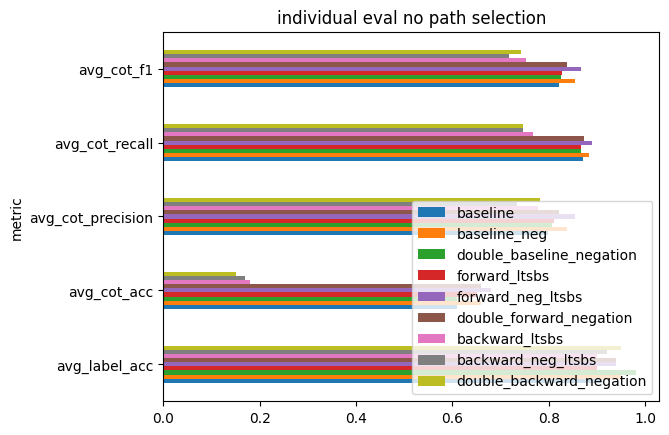

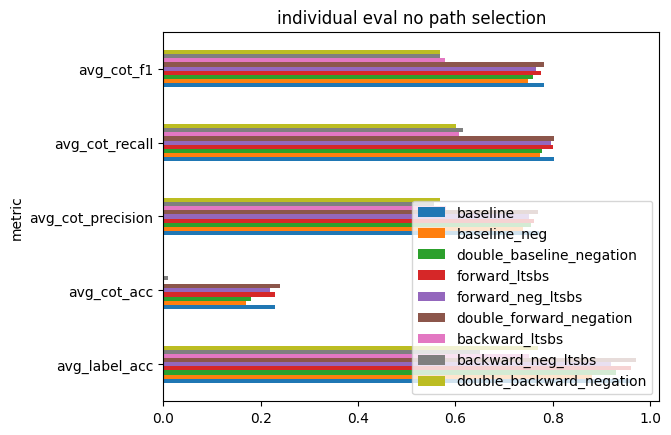

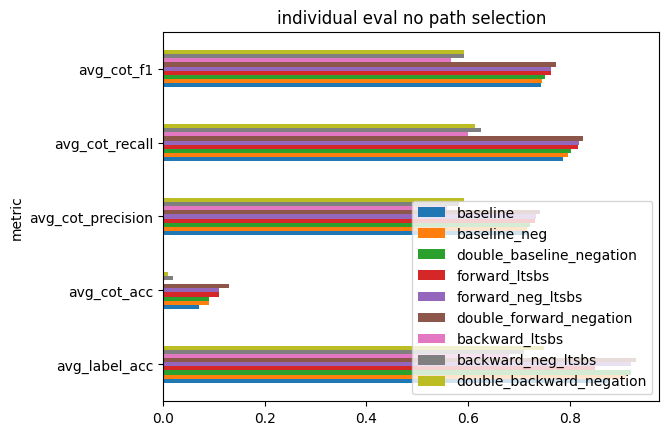

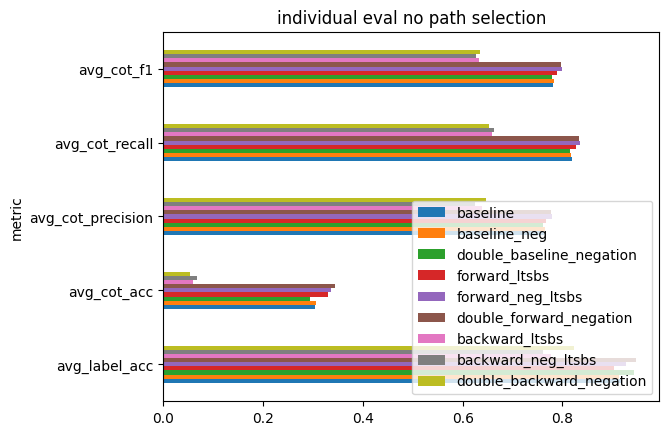

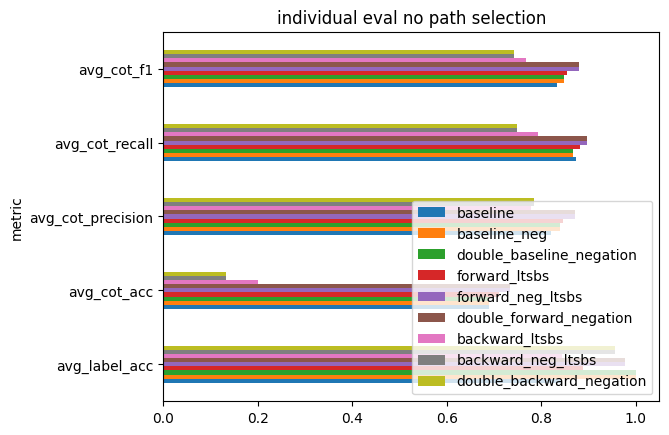

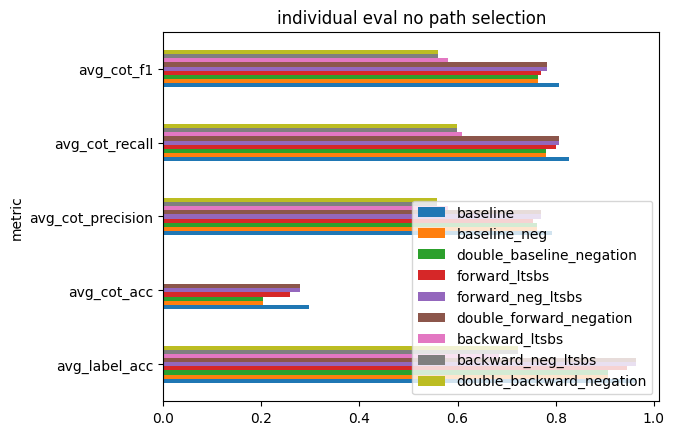

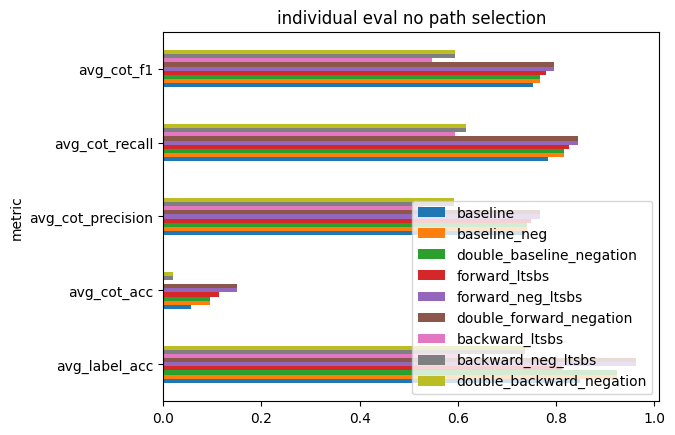

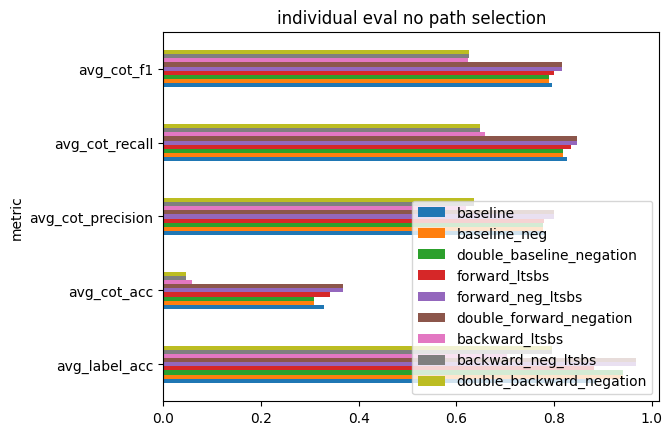

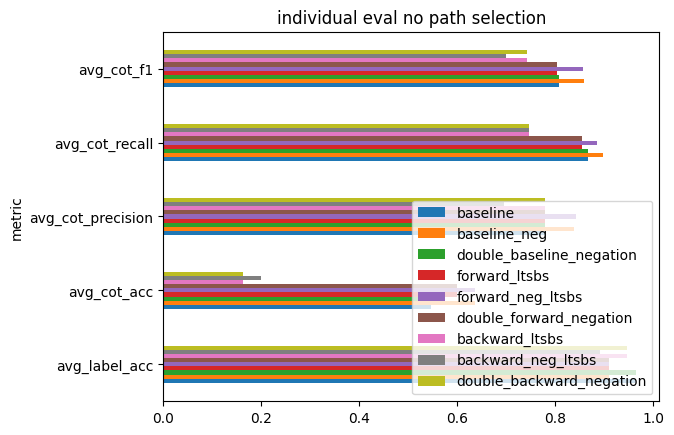

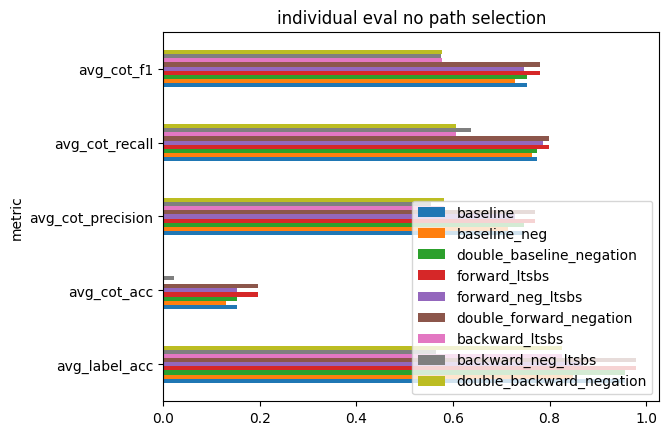

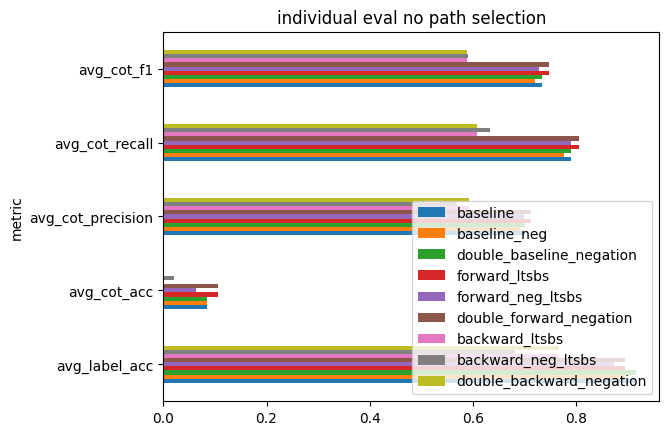

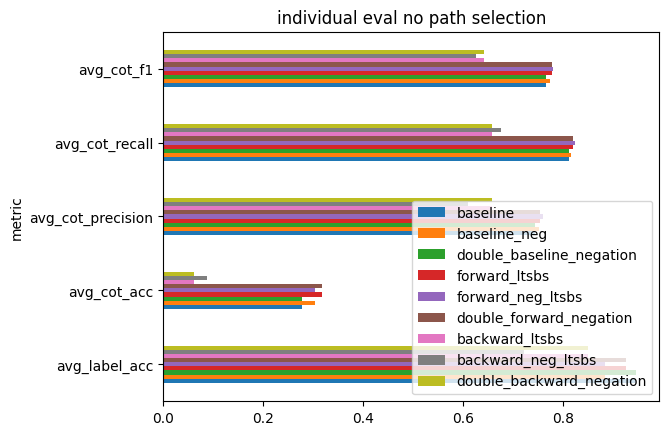

In [12]:
PROMPT_TYPES = ["baseline", "baseline_neg", "double_baseline_negation", "forward_ltsbs", "forward_neg_ltsbs", "double_forward_negation", "backward_ltsbs", "backward_neg_ltsbs", "double_backward_negation"]
columns = ["metric"] + PROMPT_TYPES
metrics_dict = {}
for restrict_type in ['none', 'not_only', 'no_not_only']:
    if restrict_type == 'none':
        dataset_type = 'all'
    else:
        dataset_type = restrict_type
    
    for k in [1, 3, 5, None]:
        for prompt_type in PROMPT_TYPES:
            metrics_dict[prompt_type] = get_metrics_dict_for_prompt_type(prompt_type, k, restrict_type)

        data = get_data_for_all_metrics(metrics_dict, PROMPT_TYPES)

        metrics_df = pd.DataFrame(
                    columns=columns,
                    data=data,
        )

        # print(metrics_df)

        # metrics_df.plot(x='metric',
        #     kind='barh',
        #     stacked=False,
        #     title="individual eval no path selection"
        # )

        # save to csv
        dir = '/sailhome/esui/cs224u_final_project/evaluate/results/single_path_selection_none'
        os.makedirs(dir, exist_ok=True)
        if k is not None:
            save_path = os.path.join(dir, f'{dataset_type}_path_selection_none_{k}hop.csv')
        else:
            save_path = os.path.join(dir, f'{dataset_type}_path_selection_none_all.csv')
        metrics_df.T.to_csv(save_path)